In [183]:
import pickle
import pandas as pd 
import keras
from keras.layers import LSTM, Activation, Dense, GRU
import keras.backend as K
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat

%matplotlib notebook
matplotlib.rcParams.update({'font.size': 12})

In [2]:
"""
ClimateAI Data Challenge starter code 

read data from pickle file, summarize the contents, and create a dataframe 

'uke_eggedal_data_challenge.pkl' contains a dictionary with the following items:
    'obs_lon_lat' - location of flow data observations
    'flow' - time series of flow data
    'flow_dates' - dates of flow data
    'obs_tas' - 9 time series of temperature data
    'obs_pr' - 9 time series of precipitation data
    'obs_dates' - dates of temperature and precipitation observations
"""

# def main():
with open('uke_eggedal_data_challenge.pkl', 'rb') as f:
    data_dict = pickle.load(f)
# summarize data in pickle file
for k, v in data_dict.items():
    print(k)
    print(type(v))
    try:
        print(v.shape)
    except AttributeError:
        print(len(v))
# create dataframe with flow data
flow_df = pd.DataFrame(data=data_dict['flow'], index=data_dict['flow_dates'], 
                       columns=['flow'])
## column names
n_locs = data_dict['obs_pr'].shape[1]
tas_cols = ['tas_{:d}'.format(i) for i in range(n_locs)]
pr_cols = ['pr_{:d}'.format(i) for i in range(n_locs)]
## create dataframes for temperature and precipitation data
tas_df = pd.DataFrame(data=data_dict['obs_tas'], index=data_dict['obs_dates'], 
                      columns=tas_cols)
pr_df = pd.DataFrame(data=data_dict['obs_pr'], index=data_dict['obs_dates'], 
                     columns=pr_cols)
## create one dataframe for all data
df = pd.concat((tas_df, pr_df, flow_df), join='inner', axis=1)
print(df.head())
# print(df.shape)


# if __name__ == '__main__':
#     main()
    
    

flow
<class 'numpy.ndarray'>
(21542,)
obs_tas
<class 'numpy.ndarray'>
(21546, 9)
flow_dates
<class 'pandas.core.series.Series'>
(21542,)
obs_lon_lat
<class 'list'>
2
obs_pr
<class 'numpy.ndarray'>
(21546, 9)
obs_dates
<class 'pandas.core.series.Series'>
(21546,)
            tas_0      tas_1  tas_2  tas_3      tas_4  tas_5      tas_6  \
1958-01-04  -12.8 -13.000000  -13.0  -12.5 -12.500000  -12.7 -12.000000   
1958-01-05   -7.8  -7.900000   -8.4   -7.0  -7.300000   -8.6  -6.500000   
1958-01-06  -11.0  -9.900000   -6.5   -8.5  -9.000000   -7.4  -7.900000   
1958-01-07  -13.2 -12.200000   -7.9  -10.7 -11.300000   -9.8 -10.100000   
1958-01-08  -19.9 -19.299999  -15.4  -18.4 -18.700001  -16.9 -17.700001   

            tas_7  tas_8  pr_0  pr_1  pr_2  pr_3  pr_4  pr_5  pr_6  pr_7  \
1958-01-04  -12.5  -12.9   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1958-01-05   -7.7   -8.3   2.0   2.2   3.0   3.3   3.7   0.7   3.1   4.2   
1958-01-06   -6.8   -5.8  12.7  11.0  16.5  12.5  11.2  12

In [3]:
# change the date index to a datetime format and add some time columns that will usefull later
df.index = pd.to_datetime(df.index)
df.insert(loc=0,column='dayofyear',value=df.index.dayofyear)
df.insert(loc=0,column='unixtime',value=df.index.values.astype(np.int64).astype(np.float64))



In [4]:
data_dict['obs_lon_lat']
# Norway

[9.37, 60.23]

In [5]:
print(df.index[0], df.index[-1])

1958-01-04 00:00:00 2015-12-31 00:00:00


<IPython.core.display.Javascript object>


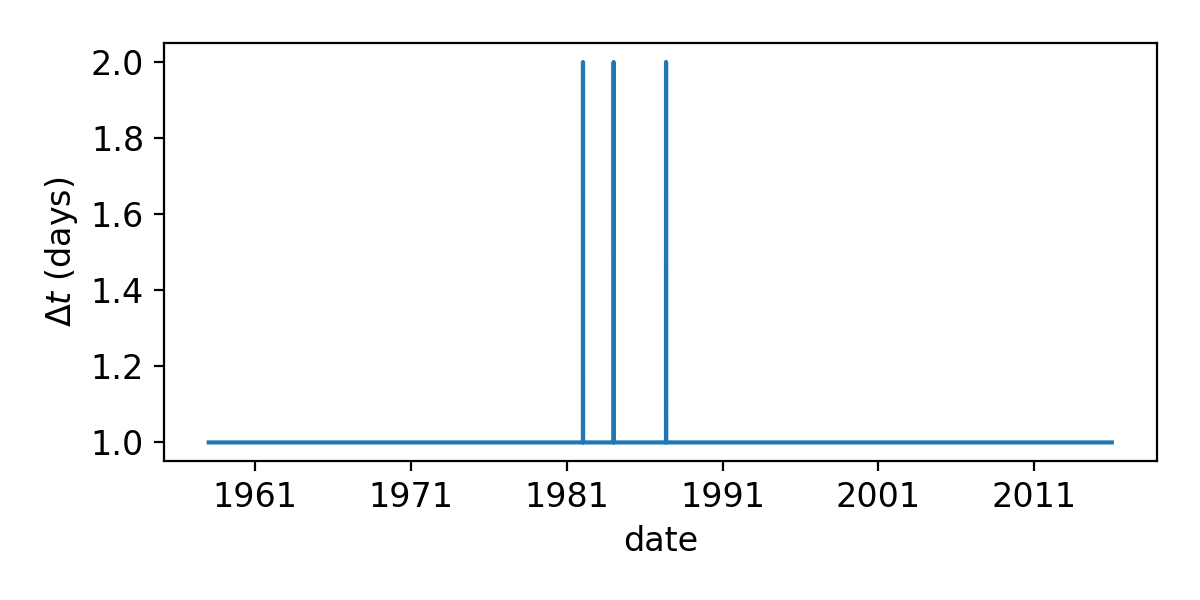

In [6]:
# is the time series sampled regularly? Does it have gaps?
plt.figure(num=1,clear=True, figsize=[6,3])
plt.plot(df.unixtime.diff() / (60*60*24*10e8))
plt.ylabel("$\Delta t$ (days)")
plt.xlabel('date')
plt.tight_layout()
plt.savefig('./plots/time_series_gaps.pdf')

### The timseries is on a regular daily interval with three 1-day gaps. The gaps are probably insignificant when training a model, but I'm going to interpolate over them anyway... because clean data

In [7]:
# linearly interpolate over the gaps in the data
df = df.resample('D').mean().interpolate()


<IPython.core.display.Javascript object>


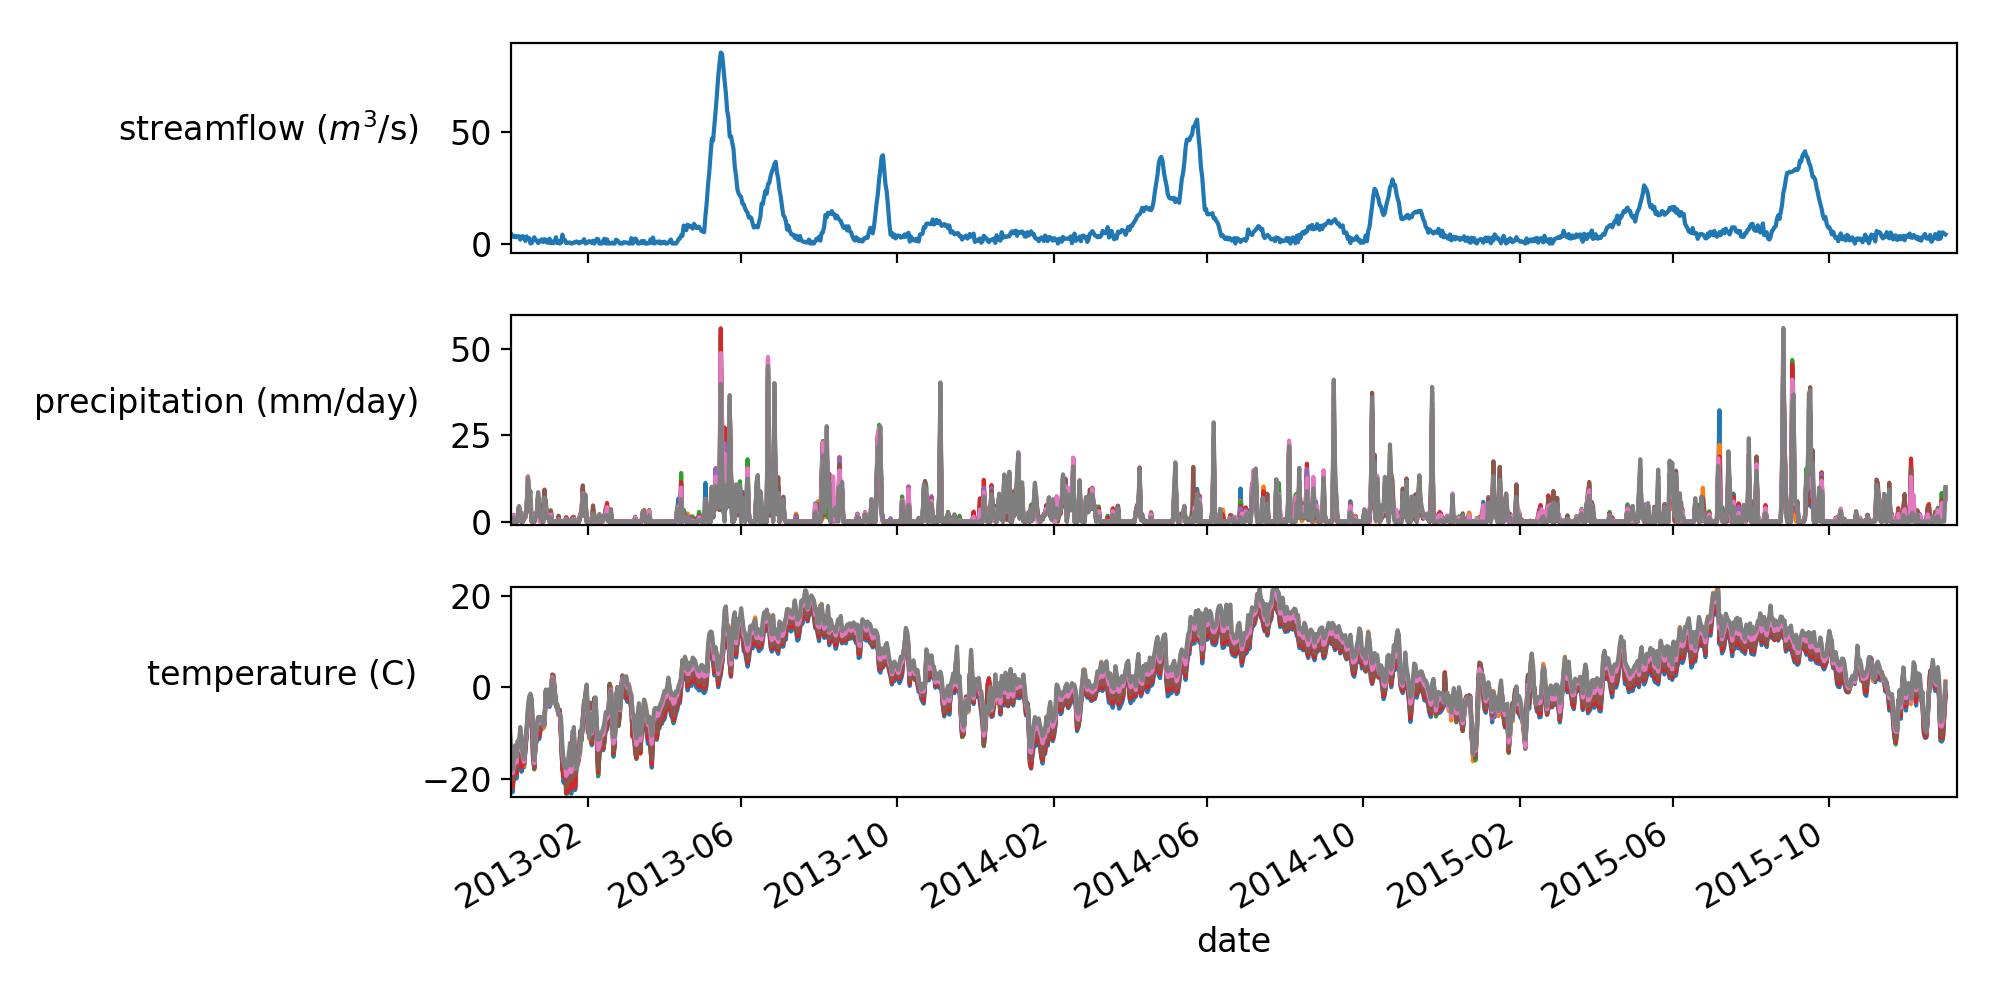

In [269]:
# plot last 3 years of data to see what it looks like
fig2 = plt.figure(num=2,clear=True, figsize=[10,5])

# streamflow
ax1 = plt.subplot(311)
plt.plot(df.index,df.iloc[:,-1])
plt.ylabel("streamflow ($m^3$/s)",rotation=0, labelpad=65)
# plt.grid(color=(.85, .85, .85), linewidth=0.75)
plt.tick_params(labelbottom='off') 

# plot the precipitation at all 8 locations
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(df.index,df.iloc[:,11:19])
plt.ylabel('precipitation (mm/day)',rotation=0, labelpad=80)
plt.ylim(-1,60)
# plt.grid(color=(.85, .85, .85), linewidth=0.75)
plt.tick_params(labelbottom='off') 

# plot the temperature across the 8 locations
ax3 = plt.subplot(313, sharex=ax1)
plt.plot(df.index,df.iloc[:,3:11])
plt.xlabel('date')
plt.ylabel('temperature (C)',rotation=0, labelpad=50)
plt.ylim(-24,22)
plt.xlim(734840, 735972)
# plt.grid(color=(.85, .85, .85), linewidth=0.75)
fig2.autofmt_xdate()

plt.tight_layout()
# plt.savefig('./plots/time_series.pdf')
# plt.savefig('./plots/time_series_mean.pdf')
# plt.savefig('./plots/time_series_nogrid.pdf')

### In general, streamflow is greatest in the spring and fall, with little or no flow during the winter. The spring flows are not always correlated with precipitation, which suggests there may be spring snowmelt. Despite some precip durring the winter the flows are low. I do not know if the precip measurement includes snow.

<IPython.core.display.Javascript object>


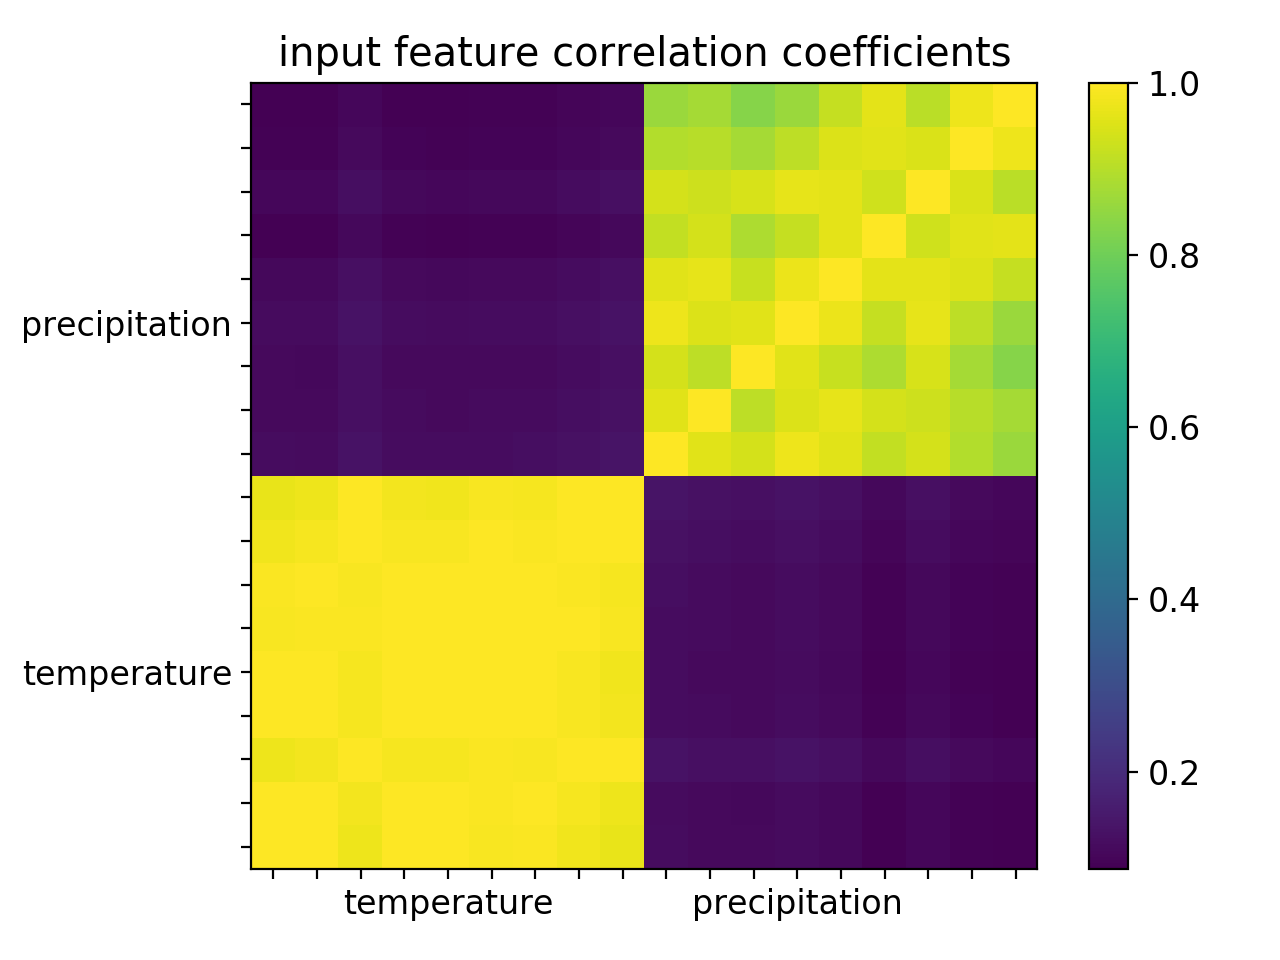

In [9]:
# let's look at correlations for the temperature and precipitation input variables 

# correlation matrix
c = np.corrcoef(df.iloc[:,2:20].transpose())

fig, ax = plt.subplots(num=4, clear=True)
plt.imshow(c);
plt.colorbar()
ax.set_xticks(np.arange(18))
ax.set_yticks(np.arange(18))
ticklabels = ['']*18
ticklabels[4] = 'temperature'
ticklabels[12] = 'precipitation'
ax.set_xticklabels(ticklabels)
ax.set_yticklabels(ticklabels)
ax.invert_yaxis()
ax.set_title('input feature correlation coefficients')

plt.tight_layout()
plt.savefig('./plots/correlations.pdf')

### The temperatures are highly correlated, the rainfalls are highly correlated but less than temperature, and temperature and precipitation are uncorrelated.  This dataset could probably be modeled with just the mean temperature and mean precip, but the dataset is not large so I'm going to use all of it. 

# What model to use?
This is an open ended task to "model" the streamflow, but there are a lot of ways to do that. 
Nowcast? 
Hindcast?
Forecast? 
If I'm going to forecast the streamflow what what forecast variables will be avaiable? 

Since forecasting is fun, let's do that! It is possible to make a forcast based on previous observations only, but since NOAA already runs some excellent process based models for temperature and precipitation forecasting out to 6 months I'm going to assume I have access to NOAA CFS (Climate Forecasting System) output. 

I'm going to train an LSTM RNN on chunks of observed data, and output the full streamflow time series for the chunk.  A forecast prediction would be made by feeding the RNN a combined chunk of observed data (up to now) and forecast data (future).

In [61]:

def ts_format_data_sequence_rand(xnorm, ynorm, timesteps, nsamples ):
    '''
    This makes nsamples chunks of time series data for taining an LSTM model that returns the full sequence. 
    The chunks all have the same length (timesteps), 
    but start at random points in the time series to avoid problems with periodic data. 
    This means the chunks can overlap, which is fine, but I should add a maximum overlap option
    '''
    if type(xnorm) is list:
        lrec=len(xnorm)
        xnorm = np.array(xnorm)
        nfeat=1 
    else:
        lrec=xnorm.shape[0]
        nfeat=xnorm.shape[1]
    
    if type(ynorm) is list:
        npredict=1 
    else:
        npredict=ynorm.shape[1]
        
    if nsamples>(lrec-timesteps):
        print('too many samples, setting number of samples to the record length - time steps')
        nsamples = lrec-timesteps
    # randomize sample starts to avoid periodic behavior, maybe this should have a min spacing
    idx = np.arange(lrec-timesteps)
    idx = np.random.permutation(idx)
    idx = idx[:nsamples]
    xout  = np.zeros( (nsamples, timesteps, nfeat) )
    yout  = np.zeros( (nsamples, timesteps, npredict) )
    for ii,nn in enumerate(idx):
        xout[ii,:,:] = xnorm[nn:(nn+timesteps),:].reshape(1,timesteps,nfeat)
        yout[ii,:,:] = ynorm[nn:(nn+timesteps),:].reshape(1,timesteps,npredict)
    return xout, yout


def ts_format_data_sequence(xnorm, ynorm, timesteps, overlap ):
    '''
    This makes nsamples chunks of time series data for taining an LSTM model that returns the full sequence. 
    The chunks all have the same length (timesteps), with each chunk overlapping the next by the number
    of overlap timesteps
    '''
    if type(xnorm) is list:
        lrec=len(xnorm)
        xnorm = np.array(xnorm)
        nfeat=1 
    else:
        lrec=xnorm.shape[0]
        nfeat=xnorm.shape[1]
    
    if type(ynorm) is list:
        npredict=1 
    else:
        npredict=ynorm.shape[1]
      
    idx = np.arange(0, lrec-timesteps, int(timesteps-overlap))
    xout  = np.zeros( (len(idx), timesteps, nfeat) )
    yout  = np.zeros( (len(idx), timesteps, npredict) )
    for ii,nn in enumerate(idx):
        xout[ii,:,:] = xnorm[nn:(nn+timesteps),:].reshape(1,timesteps,nfeat)
        yout[ii,:,:] = ynorm[nn:(nn+timesteps),:].reshape(1,timesteps,npredict)
    return xout, yout


In [273]:
# setup the data for LSTM in keras 

# time, rain, and temperature input features 
# x = df.iloc[:,0:20].values
x = df.iloc[:,0:2].values
x = np.concatenate( (x, np.mean(df.iloc[:,2:11].values,axis=1)[:,None] ), axis=1)
x = np.concatenate( (x, np.mean(df.iloc[:,11:20].values,axis=1)[:,None] ), axis=1)
nfeats = x.shape[1]
# streamflow output
y = df.iloc[:,-1].values.reshape(-1, 1)
npredict = y.shape[1]


# normalize features
xmean = np.mean(x, axis=0)
ymean = np.mean(y, axis=0)
xstd = np.std(x, axis=0)
ystd = np.std(y, axis=0)
xnorm = ( x - xmean ) / xstd
ynorm = ( y - ymean ) / ystd

# create chunks of time series data for training
# nsamples = 1000
# xseq, yseq = ts_format_data_sequence_rand( xnorm, ynorm, timesteps, nsamples )
timesteps = 360
overlap = 300
xseq, yseq = ts_format_data_sequence( xnorm, ynorm, timesteps, overlap )

print('xseq shape:', xseq.shape)
print('yseq shape:', yseq.shape)

xseq shape: (348, 360, 4)
yseq shape: (348, 360, 1)


In [274]:
# set up the LSTM model in Keras

# define custom loss fucntion for last 180 days
def mse180(yobs, ypred):
    '''rms loss function that uses only the 
       last 180 indicies of the time series'''
    return K.mean( K.square(yobs[:,-181:-1]-ypred[:,-181:-1]) )


# number of LSTM neurons per layer
nLSTM = 20
# number of LSTM layers
nLayer = 1

# setup model layers
model = keras.models.Sequential()

model.add(LSTM(nLSTM, input_shape=(timesteps, nfeats), return_sequences=True, dropout=0.3, recurrent_dropout=0.3))# implementation=2))#, use_bias=True))
for _ in range(nLayer-1):
    model.add(Activation('relu'))
    model.add(LSTM(nLSTM, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))#, use_bias=True))  
model.add(Activation('relu'))
model.add(Dense(npredict, use_bias=True))
model.add(Activation('linear'))
adamopt = keras.optimizers.Adam(lr = 0.005, decay = 7e-5)

# build model, use mse loss for time series output
# model.compile(optimizer=adamopt, loss='mean_squared_error')
model.compile(optimizer=adamopt, loss=mse180)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 360, 20)           2000      
_________________________________________________________________
activation_62 (Activation)   (None, 360, 20)           0         
_________________________________________________________________
dense_23 (Dense)             (None, 360, 1)            21        
_________________________________________________________________
activation_63 (Activation)   (None, 360, 1)            0         
Total params: 2,021
Trainable params: 2,021
Non-trainable params: 0
_________________________________________________________________


In [275]:
# train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)
history = model.fit(xseq, yseq, epochs=200, batch_size=300, validation_split=0.2, shuffle=True, callbacks=[early_stopping])

Train on 278 samples, validate on 70 samples
Epoch 1/200
278/278 [==============================] - 4s 13ms/step - loss: 1.0483 - val_loss: 1.1015
Epoch 2/200
278/278 [==============================] - 0s 1ms/step - loss: 1.0065 - val_loss: 1.0724
Epoch 3/200
278/278 [==============================] - 0s 1ms/step - loss: 0.9731 - val_loss: 1.0478
Epoch 4/200
278/278 [==============================] - 0s 1ms/step - loss: 0.9447 - val_loss: 1.0262
Epoch 5/200
278/278 [==============================] - 0s 1ms/step - loss: 0.9155 - val_loss: 1.0082
Epoch 6/200
278/278 [==============================] - 0s 1ms/step - loss: 0.9005 - val_loss: 0.9914
Epoch 7/200
278/278 [==============================] - 0s 1ms/step - loss: 0.8817 - val_loss: 0.9758
Epoch 8/200
278/278 [==============================] - 0s 1ms/step - loss: 0.8634 - val_loss: 0.9614
Epoch 9/200
278/278 [==============================] - 0s 1ms/step - loss: 0.8479 - val_loss: 0.9472
Epoch 10/200
278/278 [=======================

Epoch 81/200
278/278 [==============================] - 0s 1ms/step - loss: 0.4336 - val_loss: 0.3972
Epoch 82/200
278/278 [==============================] - 0s 1ms/step - loss: 0.4409 - val_loss: 0.3941
Epoch 83/200
278/278 [==============================] - 0s 1ms/step - loss: 0.4339 - val_loss: 0.3888
Epoch 84/200
278/278 [==============================] - 0s 1ms/step - loss: 0.4512 - val_loss: 0.3835
Epoch 85/200
278/278 [==============================] - 0s 1ms/step - loss: 0.4609 - val_loss: 0.3801
Epoch 86/200
278/278 [==============================] - 0s 1ms/step - loss: 0.4496 - val_loss: 0.3752
Epoch 87/200
278/278 [==============================] - 0s 1ms/step - loss: 0.4235 - val_loss: 0.3730
Epoch 88/200
278/278 [==============================] - 0s 1ms/step - loss: 0.3923 - val_loss: 0.3709
Epoch 89/200
278/278 [==============================] - 0s 1ms/step - loss: 0.4150 - val_loss: 0.3694
Epoch 90/200
278/278 [==============================] - 0s 1ms/step - loss: 0.4287

In [168]:
model.save_weights('/Users/dclark/Dropbox/ClimateAI/model_weights.h5') 
# SAVE HISTORY TOO?

with open('/Users/dclark/Dropbox/ClimateAI/model_history_dict', 'wb') as fout:
    pickle.dump(history.history, fout)

In [63]:
model.load_weights('/Users/dclark/Dropbox/ClimateAI/model_weights.h5') 

<IPython.core.display.Javascript object>


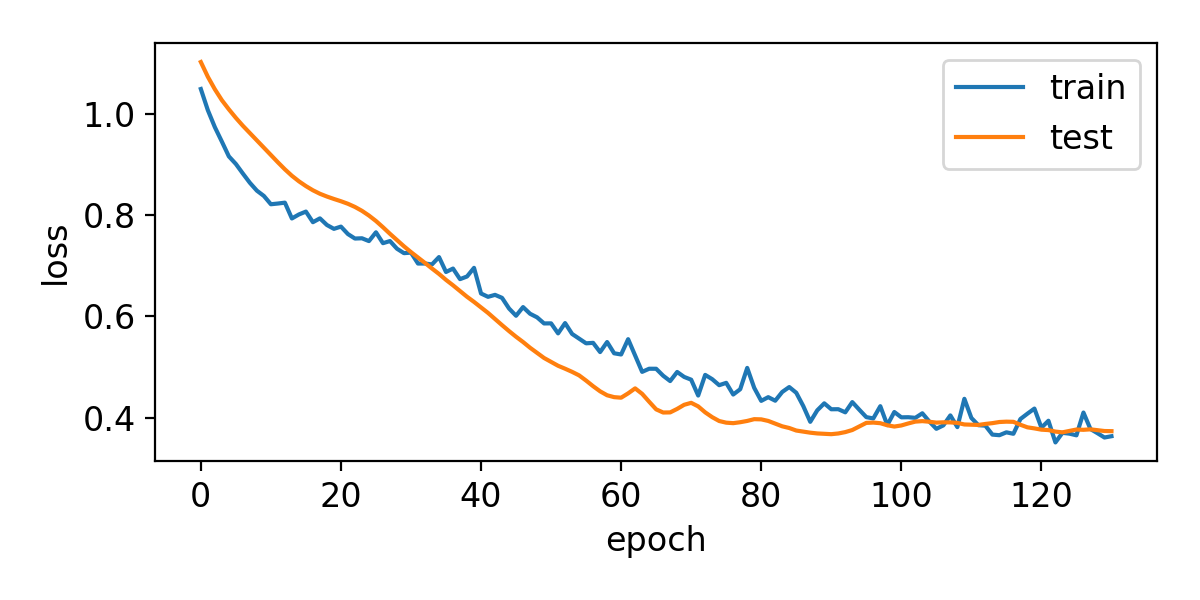

In [276]:
# plot the training and validation losses
plt.figure(num=5,clear=True, figsize=[6,3])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()
plt.savefig('./plots/train_loss.pdf')

<IPython.core.display.Javascript object>


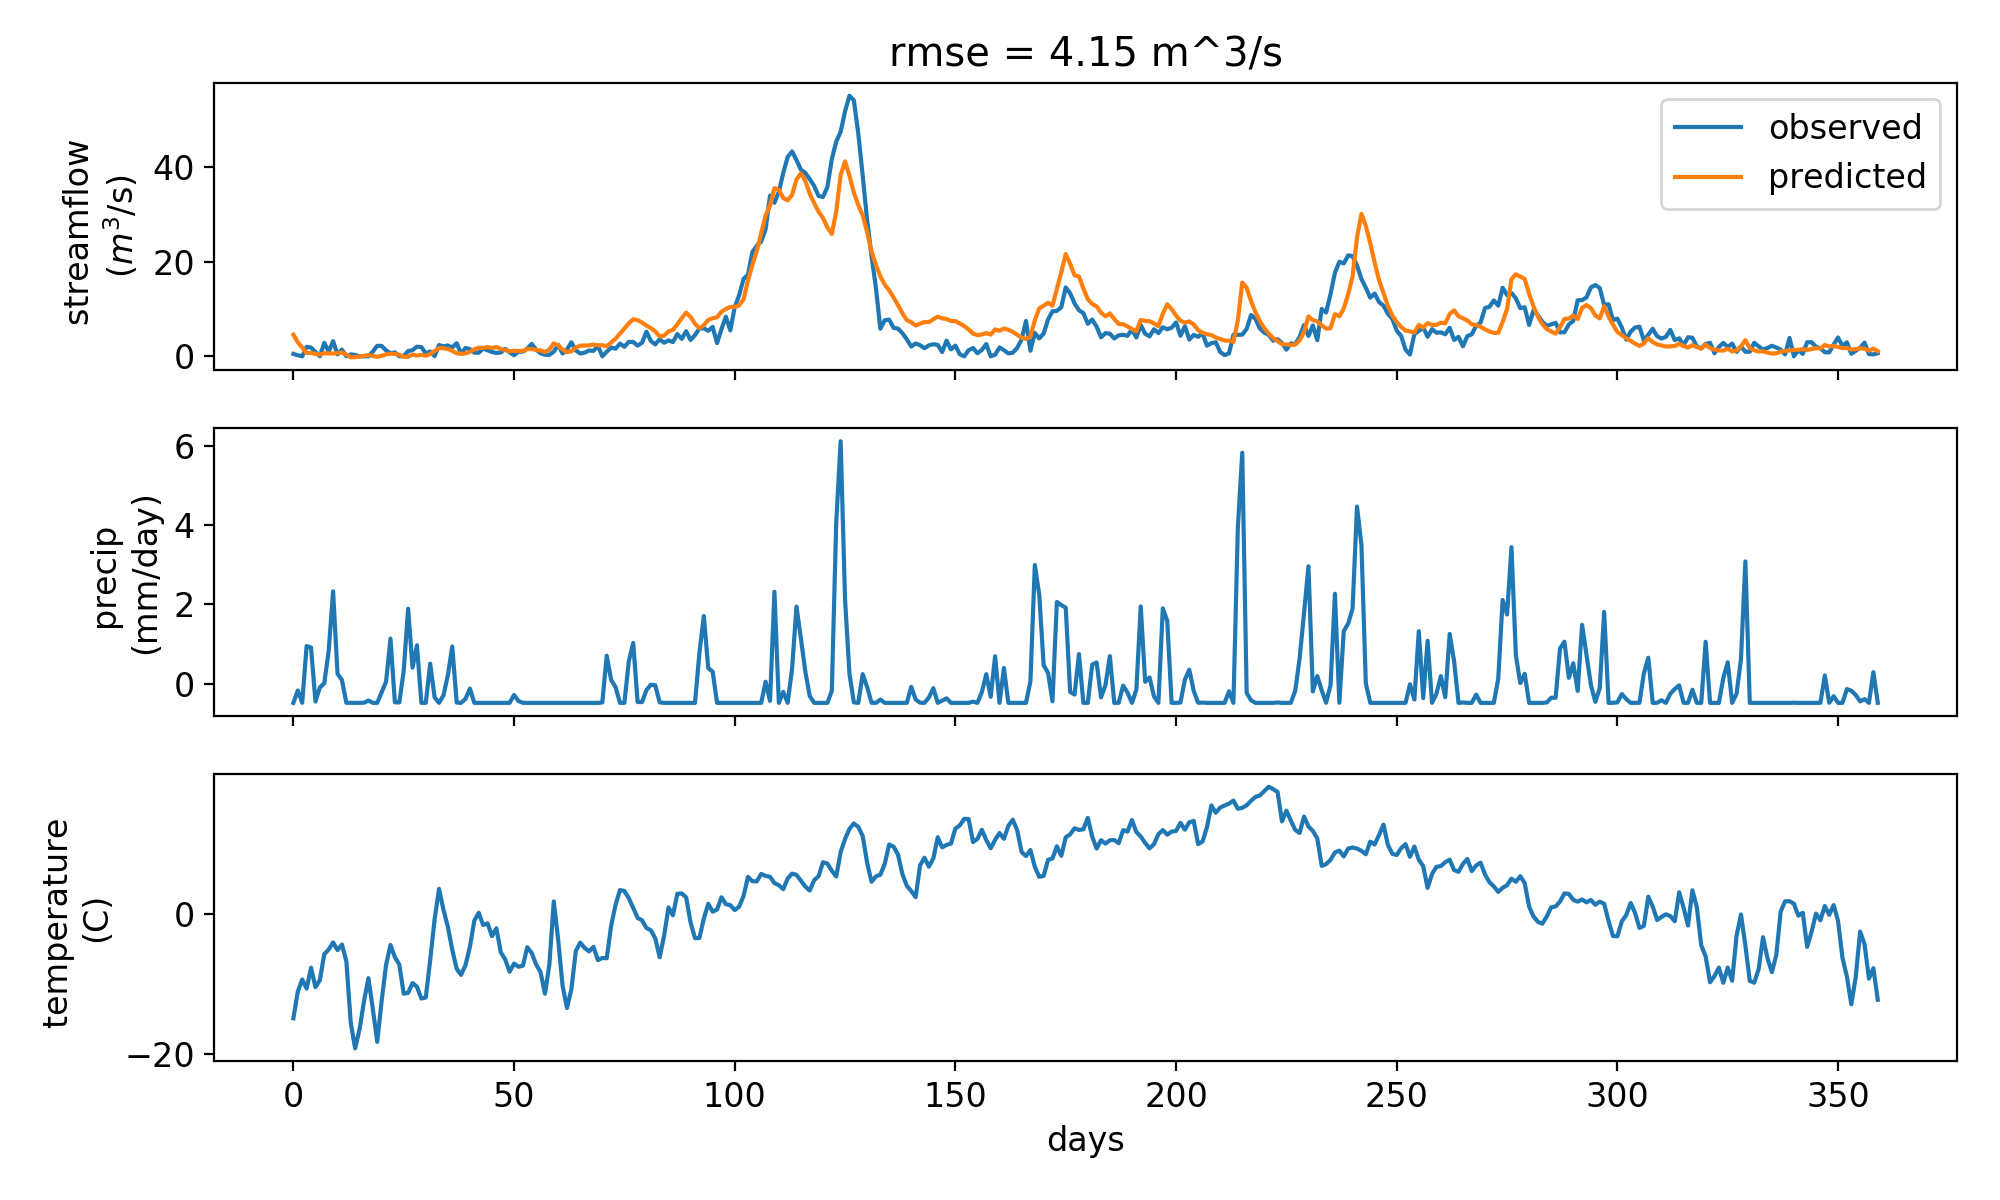

In [277]:
# grab a random chunk of the validation data and plot the model prediction 
idx = np.random.permutation(np.arange(int(0.8*yseq.shape[0]),yseq.shape[0]))[0]
# predict
yhat_seq = model.predict(xseq[idx:(idx+1),:,:])
# rescale the prediction
yhat = yhat_seq*ystd + ymean
yhat = yhat.squeeze()
# rescale the observed streamflow
y2 = yseq[idx:(idx+1),:,0].squeeze() * ystd + ymean
rmse = np.sqrt(np.mean((yhat-y2)**2))


# # mean temperature and precipitation for context 
# temp = np.mean(xseq[idx:(idx+1),:,2:10]*xstd[2:10] + xmean[2:10],axis=2).squeeze()
# precip = np.sum(xseq[idx:(idx+1),:,10:20],axis=2).squeeze()

# # rescaled temp and precip for plotting
# temp = (xseq[idx:(idx+1),:,2:11]*xstd[2:11] + xmean[2:11]).squeeze()
# precip = (xseq[idx:(idx+1),:,11:20]).squeeze()

# rescaled temp and precip for plotting
temp = (xseq[idx:(idx+1),:,2]*xstd[2] + xmean[2]).squeeze()
precip = (xseq[idx:(idx+1),:,3]).squeeze()

plt.figure(num=6, clear=True, figsize=[10,6])
ax = plt.subplot(311)
plt.plot(y2)
plt.plot(yhat)
plt.ylabel("streamflow \n($m^3$/s)")
plt.title('rmse = {:.02f} m^3/s'.format(rmse))
plt.legend(['observed','predicted'])
plt.tick_params(labelbottom='off') 

plt.subplot(312, sharex=ax)
plt.plot(precip)
plt.ylabel('precip \n(mm/day)')
plt.tick_params(labelbottom='off') 

plt.subplot(313, sharex=ax)
plt.plot(temp)
plt.ylabel('temperature \n(C)')
plt.xlabel('days')

plt.tight_layout()
plt.savefig('./plots/predict.pdf')

In [272]:
# RMS error for all velidation data
# grab a random chunk of the validation data and plot the model prediction 
idx = np.arange(int(0.8*yseq.shape[0]),yseq.shape[0])
rmse = 0
for ii in idx:
    # predict
    yhat_seq = model.predict(xseq[ii:(ii+1),:,:])
    # rescale the prediction
    yhat = yhat_seq*ystd + ymean
    yhat = yhat.squeeze()
    # rescale the observed streamflow
    y2 = yseq[ii:(ii+1),:,0].squeeze() * ystd + ymean
    rmse += np.sqrt(np.mean((yhat-y2)**2))
rmse = rmse/len(idx)
print('RMSE = {}'.format(rmse))

RMSE = 6.273817619463742


<IPython.core.display.Javascript object>


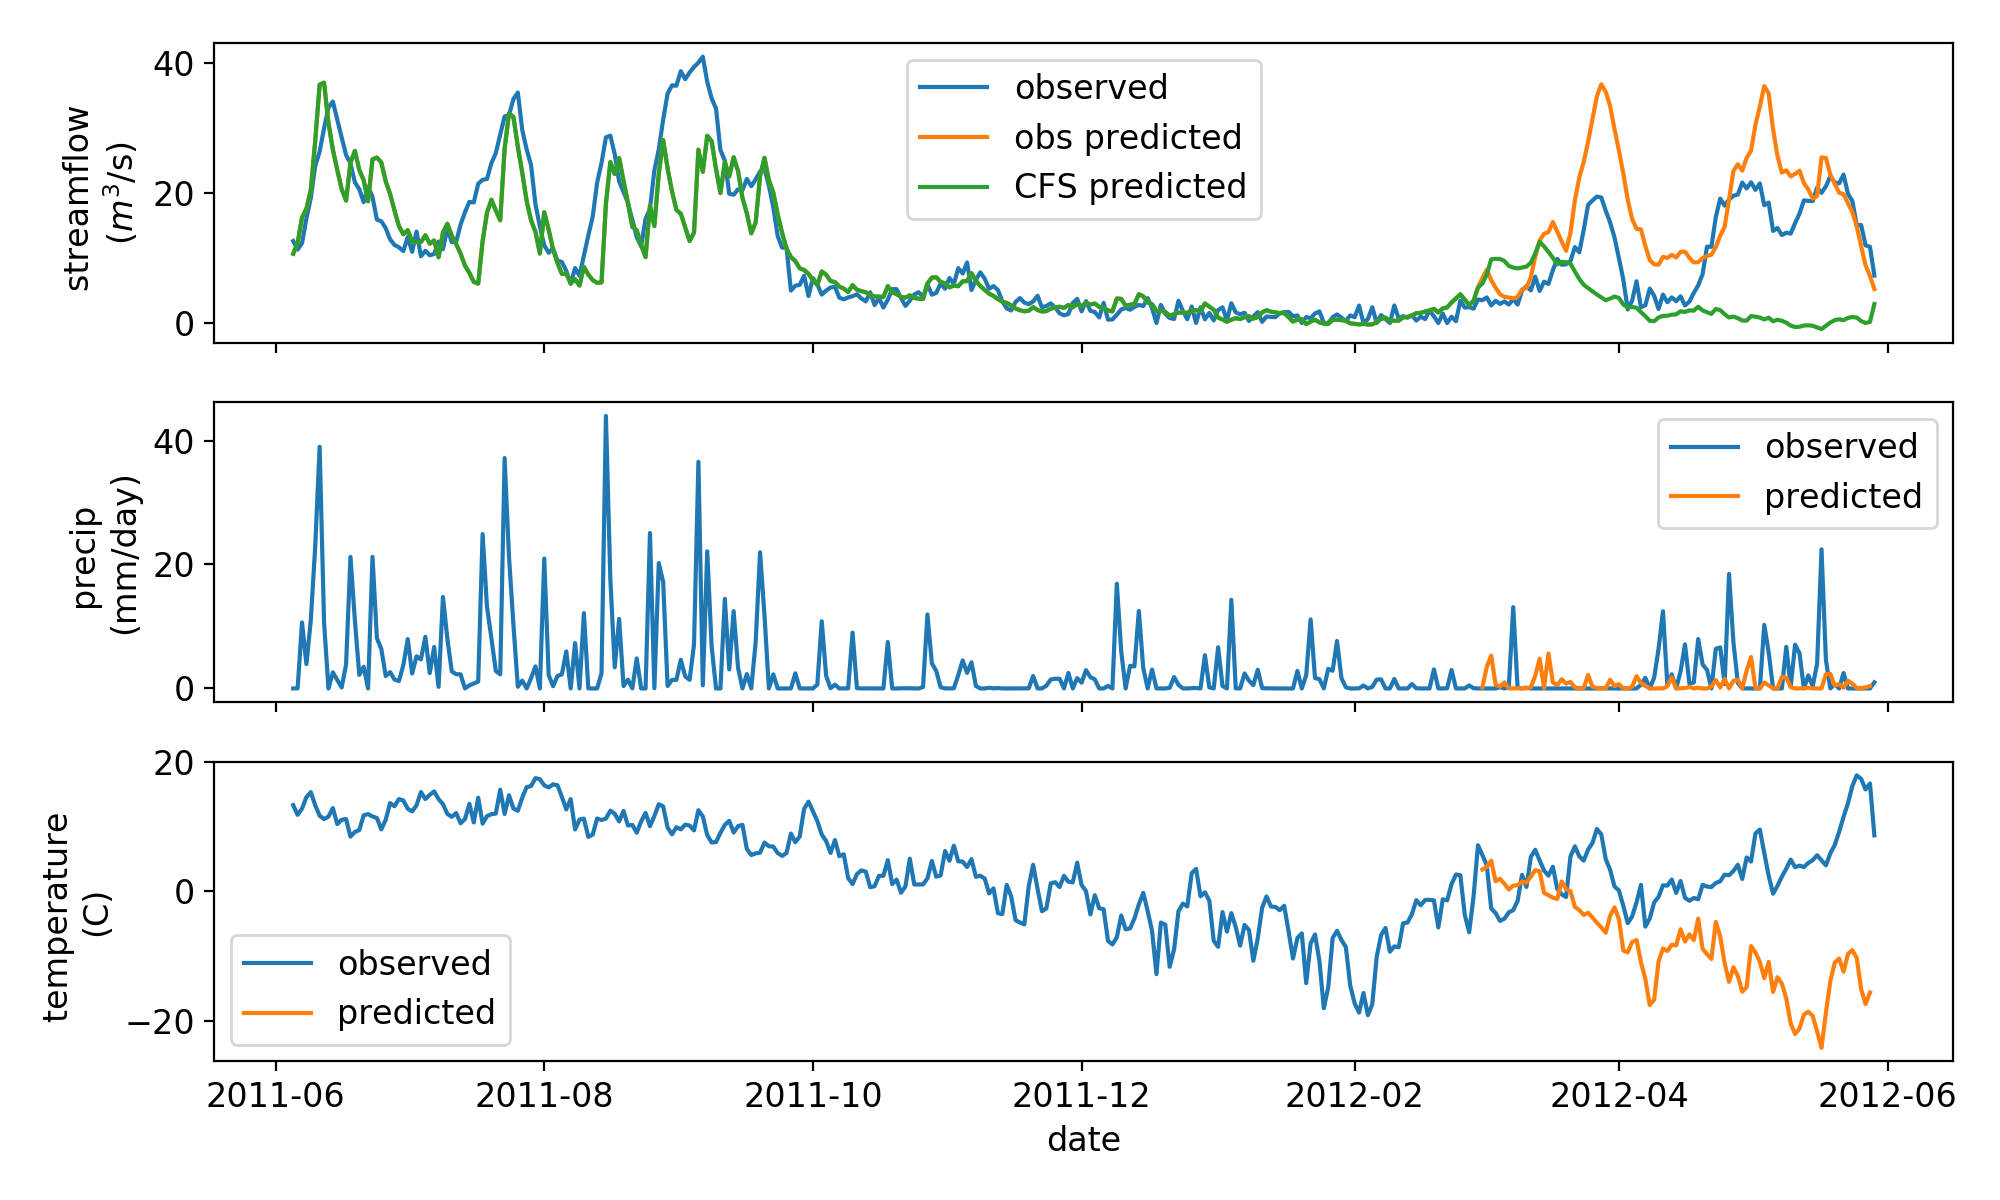

In [279]:
# CFS forecast data from January 2015, daily, starting Jan-1st
cfs = loadmat('Eggedal_daily_rain_temp_20120301.mat');
cfs_temp = np.array(cfs['tempd'])-5
cfs_rain = np.array(cfs['raind'])

# forecast length (days)
forecast_len = 90
# index 19780 is 2012-03-01 
cidx =19780

dfbackvals = df.iloc[(cidx-timesteps + forecast_len):(cidx+forecast_len), 0:21]
y2 = dfbackvals.iloc[:,-1].values.reshape(-1, 1)
x2 = dfbackvals.iloc[:,0:2].values
x2 = np.concatenate( (x2, np.mean(dfbackvals.iloc[:,2:11].values,axis=1)[:,None] ), axis=1)
x2 = np.concatenate( (x2, np.mean(dfbackvals.iloc[:,11:20].values,axis=1)[:,None] ), axis=1)
x3 = x2.copy()
x3[-forecast_len:-1,3] = cfs_rain[0,-forecast_len:-1]
x3[-forecast_len:-1,2] = cfs_temp[0,-forecast_len:-1]
x3norm = ((x3-xmean)/xstd).reshape(1,x3.shape[0],x3.shape[1])
x2norm = ((x2-xmean)/xstd).reshape(1,x2.shape[0],x2.shape[1])

# predict
yhat_seq3 = model.predict(x3norm)
yhat_seq2 = model.predict(x2norm)
# rescale the prediction
yhat3 = yhat_seq3*ystd + ymean
yhat3 = yhat3.squeeze()
yhat2 = yhat_seq2*ystd + ymean
yhat2 = yhat2.squeeze()
# sorta time
t = dfbackvals.index.values

plt.figure(num=7, clear=True, figsize=[10,6])
ax = plt.subplot(311)
plt.plot(t,y2)
plt.plot(t,yhat2)
plt.plot(t,yhat3)
plt.ylabel("streamflow \n($m^3$/s)")
plt.legend(['observed','obs predicted','CFS predicted'])
plt.tick_params(labelbottom='off') 

plt.subplot(312, sharex=ax)
plt.plot(t,x2[:,3])
plt.plot(t[-forecast_len:-1],x3[-forecast_len:-1,3])
plt.ylabel('precip \n(mm/day)')
plt.tick_params(labelbottom='off') 
plt.legend(['observed','predicted'])

plt.subplot(313, sharex=ax)
plt.plot(t,x2[:,2])
plt.plot(t[-forecast_len:-1],x3[-forecast_len:-1,2])
plt.ylabel('temperature \n(C)')
plt.xlabel('date')
plt.legend(['observed','predicted'])


plt.tight_layout()

plt.savefig('./plots/CFS_predict.pdf')


